In [40]:
import matplotlib
%matplotlib inline

In [2]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

import seaborn as sns

import os
os.chdir("/home/ec2-user/scVI/")
os.getcwd()

from umap import UMAP

use_cuda = True
import torch

# import data loading functions

In [3]:
from scvi.harmonization.utils_chenling import get_matrix_from_dir
from scvi.dataset.pbmc import PbmcDataset
from scvi.harmonization.utils_chenling import assign_label
import numpy as np
from scvi.dataset.dataset import GeneExpressionDataset
from copy import deepcopy


# import scVI models

In [4]:
from scvi.inference import UnsupervisedTrainer, SemiSupervisedTrainer
from scvi.models.scanvi import SCANVI
from scvi.models.vae import VAE

In [5]:
dataset1 = PbmcDataset(filter_out_de_genes=False)
dataset1.update_cells(dataset1.batch_indices.ravel()==0)
dataset1.subsample_genes(dataset1.nb_genes)

count, geneid, cellid = get_matrix_from_dir('cite')
count = count.T.tocsr()
seurat = np.genfromtxt('../cite/cite.seurat.labels', dtype='str', delimiter=',')
cellid = np.asarray([x.split('-')[0] for x in cellid])
labels_map = [0, 0, 1, 2, 3, 4, 5, 6]
labels = seurat[1:, 4]
cell_type = ['CD4 T cells', 'NK cells', 'CD14+ Monocytes', 'B cells','CD8 T cells', 'FCGR3A+ Monocytes', 'Other']
dataset2 = assign_label(cellid, geneid, labels_map, count, cell_type, seurat)
set(dataset2.cell_types).intersection(set(dataset2.cell_types))


File data/gene_info_pbmc.csv already downloaded
File data/pbmc_metadata.pickle already downloaded
File data/10X/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 33694 to 21425 genes
Downsampling from 8381 to 8381 cells
File data/10X/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 33694 to 19773 genes
Downsampling from 4340 to 4340 cells
Keeping 19039 genes
Downsampling from 12721 to 11990 cells
Downsampling from 19039 to 19036 genes
Downsampling from 11990 to 11990 cells
Downsampling from 11990 to 7982 cells


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:536: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:604: RuntimeWarning: Degrees of freedom <= 0 for slice
  return N.ndarray.var(self, axis, dtype, out, ddof, keepdims=True)._collapse(axis)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:125: RuntimeWarning: i

Downsampling from 19036 to 19011 genes
Downsampling from 7982 to 7982 cells


{'B cells',
 'CD14+ Monocytes',
 'CD4 T cells',
 'CD8 T cells',
 'FCGR3A+ Monocytes',
 'NK cells',
 'Other'}

In [6]:
rmCellTypes = 'B cells'

In [7]:
pbmc = deepcopy(dataset1)
newCellType = [k for i, k in enumerate(dataset1.cell_types) if k not in [rmCellTypes]]
pbmc.filter_cell_types(newCellType)
pbmc2 = deepcopy(dataset2)
pbmc2.filter_cell_types([rmCellTypes])
gene_dataset = GeneExpressionDataset.concat_datasets(pbmc, pbmc2)

Downsampling from 7982 to 6922 cells
Downsampling from 6616 to 685 cells
Keeping 14968 genes


In [8]:
rm_idx = np.arange(len(gene_dataset.cell_types))[gene_dataset.cell_types == rmCellTypes][0]

In [9]:
gene_dataset.cell_types[rm_idx] == rmCellTypes

True

In [10]:
pbmc3 = deepcopy(pbmc2)
pbmc3.cell_types = ['CD4 T cells']
false_gene_dataset = GeneExpressionDataset.concat_datasets(pbmc, pbmc3)

Keeping 14968 genes


In [11]:
pbmc.cell_types

array(['CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells', 'Dendritic Cells',
       'FCGR3A+ Monocytes', 'Megakaryocytes', 'NK cells', 'Other'],
      dtype=object)

In [12]:
pbmc3.cell_types

['CD4 T cells']

In [13]:
pbmc2.cell_types

array(['B cells'], dtype='<U17')

In [14]:
gene_dataset.subsample_genes(1000)
false_gene_dataset.subsample_genes(1000)

Downsampling from 14968 to 14962 genes
Downsampling from 7607 to 7607 cells


/home/ec2-user/scVI/scvi/dataset/dataset.py:178: RuntimeWarning: divide by zero encountered in true_divide
  subset_genes = np.argsort(std_scaler.var_ / std_scaler.mean_)[::-1][:new_n_genes]
/home/ec2-user/scVI/scvi/dataset/dataset.py:178: RuntimeWarning: invalid value encountered in true_divide
  subset_genes = np.argsort(std_scaler.var_ / std_scaler.mean_)[::-1][:new_n_genes]


Downsampling from 14962 to 1938 genes
Downsampling from 14962 to 1938 genes
Downsampling from 7607 to 7607 cells
Downsampling from 14968 to 14962 genes
Downsampling from 7607 to 7607 cells
Downsampling from 14962 to 1938 genes
Downsampling from 14962 to 1938 genes
Downsampling from 7607 to 7607 cells


In [15]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches,
      n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
if os.path.isfile('../NoOverlap/posterior.vae.%s.pkl' % rmCellTypes.replace(' ','')):
    trainer.model.load_state_dict(torch.load('../NoOverlap/posterior.vae.%s.pkl' % rmCellTypes.replace(' ','')))
    trainer.model.eval()
else:
    trainer.train(n_epochs=250)
    torch.save(trainer.model.state_dict(), '../NoOverlap/posterior.vae.%s.pkl' % rmCellTypes.replace(' ',''))

In [16]:
from scvi.inference import AlternateSemiSupervisedTrainer,SemiSupervisedTrainer

scanvi = SCANVI(gene_dataset.nb_genes, gene_dataset.n_batches, gene_dataset.n_labels,
                  n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
scanvi.load_state_dict(trainer.model.state_dict(), strict=False)
# trainer_scanvi = SemiSupervisedTrainer(scanvi, gene_dataset, n_epochs_classifier=1, lr_classification=5 * 1e-3)
trainer_scanvi = AlternateSemiSupervisedTrainer(scanvi, gene_dataset, n_epochs_classifier=100, lr_classification=5 * 1e-3)
trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=(gene_dataset.batch_indices == 0))
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=(gene_dataset.batch_indices == 1))
trainer_scanvi.train(n_epochs=5)


training: 100%|██████████| 5/5 [00:41<00:00,  8.21s/it]


In [17]:
unlabelled_idx = trainer_scanvi.unlabelled_set.indices

In [18]:
full_scanvi = trainer_scanvi.create_posterior(trainer_scanvi.model, gene_dataset, indices=np.arange(len(gene_dataset)))
all_y_pred = []
for i_batch, tensors in enumerate(full_scanvi.sequential()):
    sample_batch, _, _, _, _ = tensors
    all_y_pred += [scanvi.classify(sample_batch)]

all_y_pred = np.array(torch.cat(all_y_pred))    
max_prob=(np.max(all_y_pred,axis=1))

In [19]:
y,y_pred = full_scanvi.sequential().compute_predictions()

In [20]:
np.sum(gene_dataset.labels.ravel()==y) == len(y)

True

In [21]:
gene_dataset.cell_types

array(['CD4 T cells', 'B cells', 'CD8 T cells', 'Megakaryocytes',
       'NK cells', 'CD14+ Monocytes', 'Other', 'Dendritic Cells',
       'FCGR3A+ Monocytes'], dtype='<U17')

In [22]:
np.unique(y_pred[gene_dataset.batch_indices.ravel()==0],return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([3293,   24, 1001,   52,  281, 1478,  365,  213,  215]))

In [23]:
np.unique(y_pred[gene_dataset.batch_indices.ravel()==1],return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 18, 638,  21,   1,   3,   4]))

In [24]:
rm_idx = [i for i,x in enumerate(gene_dataset.cell_types) if x==rmCellTypes]

In [25]:
max_prob=(np.max(np.delete(all_y_pred,rm_idx,1),axis=1))

In [26]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.hist(max_prob[gene_dataset.batch_indices.ravel() ==1], 30, alpha=0.5, label='Maximum Prob of Observed Classes for Unlabeled B Cells')
plt.hist(max_prob[gene_dataset.batch_indices.ravel() !=1], 30, alpha=0.5, label='Maximum Prob of Observed Classes for All Other Cells')
plt.legend(loc='upper left',bbox_to_anchor=(0, 1.2))
fig.tight_layout()
fig.savefig("figures/SCANVI_NoOverlap_posterior.pdf", transparency=True)
# plt.show()

In [27]:
np.unique(y_pred[gene_dataset.batch_indices.ravel()==0],return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([3293,   24, 1001,   52,  281, 1478,  365,  213,  215]))

In [28]:
np.unique(y_pred[gene_dataset.batch_indices.ravel()==1],return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 18, 638,  21,   1,   3,   4]))

In [29]:
from scvi.metrics.clustering import select_indices_evenly

In [30]:
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))

latent, batch_indices, _ = full.sequential().get_latent()

In [31]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
key_order = [x for x in key_order if (keys[x] !='Other')]


In [32]:
labels = gene_dataset.labels.ravel()

sample = select_indices_evenly(2000, labels)
colors = sns.color_palette('tab20')
latent_s = latent[sample, :]
label_s = labels[sample]
batch_s = batch_indices.ravel()[sample]

from umap import UMAP
latent_u = UMAP(spread=2).fit_transform(latent_s)



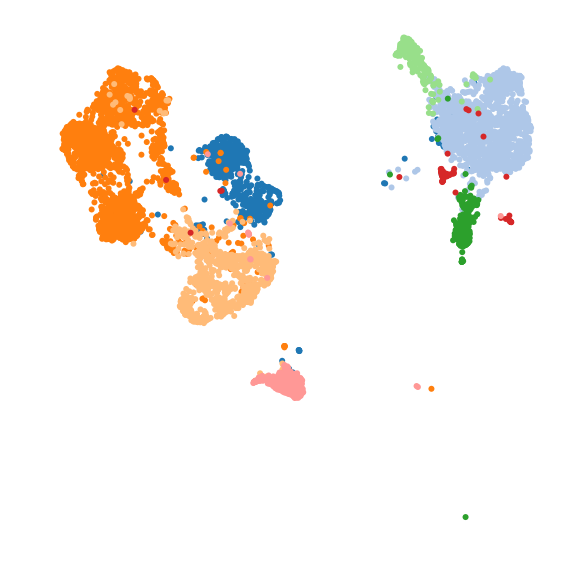

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))
for i,k in enumerate(key_order):
    idx = label_s==k
    ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none')
# plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/SCANVI_stress_vaeUMAP_labels.pdf", transparency=True)


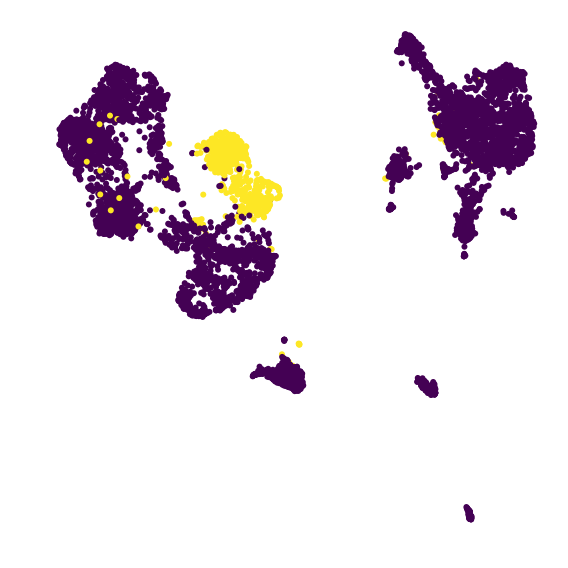

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(latent_u[:, 0], latent_u[:, 1], c=batch_s, label=k,
               edgecolors='none')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/SCANVI_stress_vaeUMAP_batch.pdf", transparency=True)


### SCANVI latent space

In [35]:
latent_scanvi, _, _ = full_scanvi.sequential().get_latent()

In [36]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
labels = gene_dataset.labels.ravel()
batch_indices = gene_dataset.batch_indices.ravel()
sample = select_indices_evenly(2000, labels)
colors = sns.color_palette('tab20')
latent_s = latent_scanvi[sample, :]
label_s = labels[sample]
batch_s = batch_indices.ravel()[sample]
latent_scanvi_u = UMAP(spread=2).fit_transform(latent_s)

key_order = [x for x in key_order if (keys[x] !='Other')]


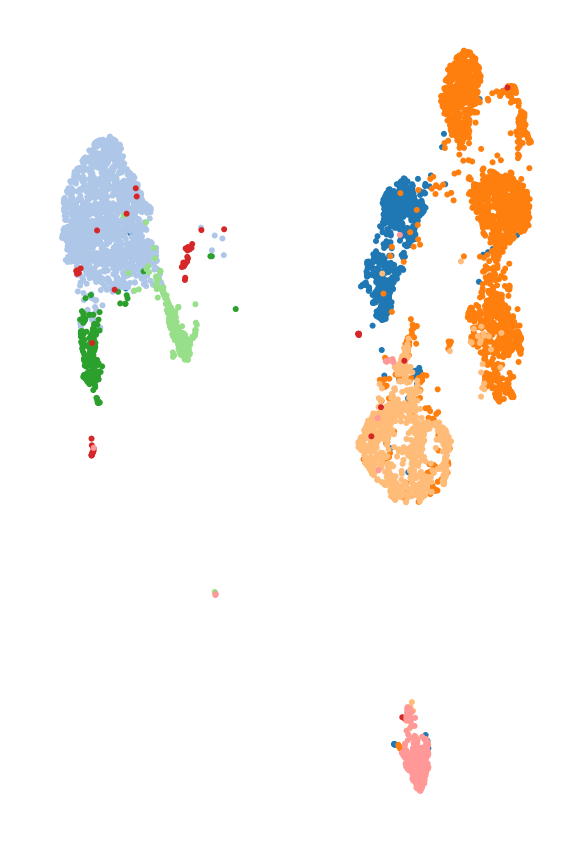

In [43]:

colors = sns.color_palette('tab20')
fig, ax = plt.subplots(figsize=(8, 12))
for i,k in enumerate(key_order):
    idx = (label_s ==k)
    ax.scatter(latent_scanvi_u[idx, 0], latent_scanvi_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none')
#     plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/SCANVI_stress_scanviUMAP_labels.txt.pdf", transparency=True)


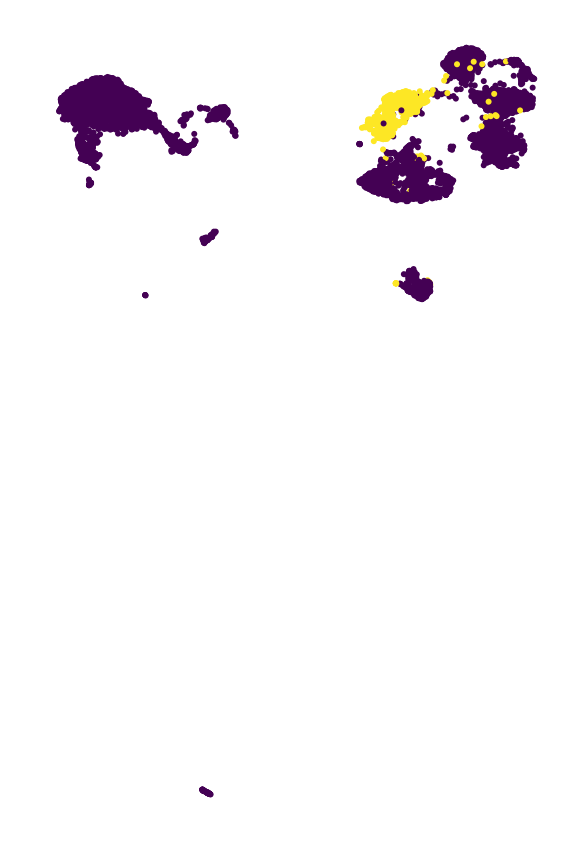

In [44]:
fig, ax = plt.subplots(figsize=(8, 12))
ax.scatter(latent_scanvi_u[:, 0], latent_scanvi_u[:, 1], c=batch_s, label=k,
               edgecolors='none')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/SCANVI_stress_scanviUMAP_batch.pdf", transparency=True)
